In [ ]:
import sys
!{sys.executable} -m pip install geopandas

In [ ]:
import sys
!{sys.executable} -m pip install geopy

In [3]:
import pandas as pd
import numpy as np

from datetime import timedelta
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPoint
from geopy.distance import distance
from pyproj import Proj, transform
import requests
import json
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = '/content/drive/MyDrive/WILDFIRE/Database/Wildfire_updt'
#finalWeather = pd.read_csv(BASE_PATH + '/finalWeatherData.csv')
fireWeathers = pd.read_csv(BASE_PATH + '/fire_areas2.0.csv').iloc[:,1:67]
# read data with the averages for durations in each wildfire

In [ ]:
fireWeathers.shape

(4984, 66)

In [ ]:
# finding top 5 largest wildfires by area roc
fireWeathers.sort_values('area_roc', axis = 0, ascending = False)['IncidentName'].unique()[0:5]
#fireWeathers = fireWeathers.sort_values('area_change', axis = 0, ascending = False)

array(['IKES', '204 Cow', 'Trumbull', 'MP 97', 'McClusky'], dtype=object)

In [ ]:
Y = fireWeathers['area_roc']
logY = np.log(Y)
X = fireWeathers.drop(columns = ['area_roc', 'acq_time_x','area_change', 'isotimes','drop', 'IncidentName', 'geometry', 'startTime', 'endTime','time', 'scan', 'track','acq_date_y','acq_time_y', 'bright_t31', 'confidence','frp', 'type', 'coords_left', 'index_right', 'OBJECTID', 'IncidentNa_x', 'IncidentNa_y', 'GISAcres', 'IRWINID', 'missing_data', 'FireDiscoveryDateTime_y', 'coords_right'])
# create binary variable for if date is before or after containment date - 1 if after, 0 if before 
# ^ nvm - no dates after containment date
X.head()
X1 = pd.get_dummies(X)

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4984 entries, 0 to 4983
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   acq_date_x                     4984 non-null   object 
 1   area                           4984 non-null   float64
 2   temperature_2m                 4309 non-null   float64
 3   dewpoint_2m                    4309 non-null   float64
 4   relativehumidity_2m            4309 non-null   float64
 5   pressure_msl                   4309 non-null   float64
 6   precipitation                  4309 non-null   float64
 7   rain                           4309 non-null   float64
 8   snowfall                       4309 non-null   float64
 9   cloudcover                     4309 non-null   float64
 10  cloudcover_low                 4309 non-null   float64
 11  cloudcover_mid                 4309 non-null   float64
 12  cloudcover_high                4309 non-null   f

In [ ]:
#X['afterContainmentDate'] = X['acq_date_x'] >= X['ContainmentDateTime_y']
#X = X.drop(['afterContainmentDate', 'acq_date_x', 'ContainmentDateTime_y'], axis=1)

In [ ]:
X = X.drop(['acq_date_x', 'ContainmentDateTime_y','FireOutDateTime'], axis=1)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4984 entries, 0 to 4983
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   area                           4984 non-null   float64
 1   temperature_2m                 4309 non-null   float64
 2   dewpoint_2m                    4309 non-null   float64
 3   relativehumidity_2m            4309 non-null   float64
 4   pressure_msl                   4309 non-null   float64
 5   precipitation                  4309 non-null   float64
 6   rain                           4309 non-null   float64
 7   snowfall                       4309 non-null   float64
 8   cloudcover                     4309 non-null   float64
 9   cloudcover_low                 4309 non-null   float64
 10  cloudcover_mid                 4309 non-null   float64
 11  cloudcover_high                4309 non-null   float64
 12  windspeed_10m                  4309 non-null   f

In [ ]:
catData = X[['PrimaryFuelModel', 'SecondaryFuelModel', 'FireCause', 'IsVisible', 'daynight']]

catData = pd.get_dummies(catData)



In [ ]:
X_combined = pd.concat([X, catData], axis=1)

In [ ]:
X_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4984 entries, 0 to 4983
Data columns (total 63 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   area                                               4984 non-null   float64
 1   temperature_2m                                     4309 non-null   float64
 2   dewpoint_2m                                        4309 non-null   float64
 3   relativehumidity_2m                                4309 non-null   float64
 4   pressure_msl                                       4309 non-null   float64
 5   precipitation                                      4309 non-null   float64
 6   rain                                               4309 non-null   float64
 7   snowfall                                           4309 non-null   float64
 8   cloudcover                                         4309 non-null   float64
 9   cloudcov

In [ ]:
X_combined = X_combined.drop(['PrimaryFuelModel', 'SecondaryFuelModel', 'FireCause', 'IsVisible', 'daynight'], axis=1)

In [ ]:
X_combined.to_csv(BASE_PATH + '/final_data_predictors1.csv')

In [ ]:
X_pred = pd.read_csv(BASE_PATH + '/final_data_predictors1.csv').iloc[:,1:59]
X_pred = X_combined
#X_pred = X_pred.drop(['FireOutDateTime'], axis = 1)

In [ ]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4984 entries, 0 to 4983
Data columns (total 58 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   area                                               4984 non-null   float64
 1   temperature_2m                                     4309 non-null   float64
 2   dewpoint_2m                                        4309 non-null   float64
 3   relativehumidity_2m                                4309 non-null   float64
 4   pressure_msl                                       4309 non-null   float64
 5   precipitation                                      4309 non-null   float64
 6   rain                                               4309 non-null   float64
 7   snowfall                                           4309 non-null   float64
 8   cloudcover                                         4309 non-null   float64
 9   cloudcov

In [ ]:
data = pd.concat([logY, X_pred], axis = 1)
data.shape

(4984, 59)

In [ ]:
data_final = data.dropna(axis = 0)
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3361 entries, 4 to 4859
Data columns (total 59 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   area_roc                                           3361 non-null   float64
 1   area                                               3361 non-null   float64
 2   temperature_2m                                     3361 non-null   float64
 3   dewpoint_2m                                        3361 non-null   float64
 4   relativehumidity_2m                                3361 non-null   float64
 5   pressure_msl                                       3361 non-null   float64
 6   precipitation                                      3361 non-null   float64
 7   rain                                               3361 non-null   float64
 8   snowfall                                           3361 non-null   float64
 9   cloudcov

In [ ]:
Y_final = data_final.iloc[:,0]
X_final = data_final.iloc[:,1:57]


inf

In [ ]:
inf_index = []
for i in range(len(data_final.iloc[:,0])):
  if (data_final.iloc[i,0] > 9999999):
    inf_index.append(i)

In [ ]:
X_final.head()

,area,temperature_2m,dewpoint_2m,relativehumidity_2m,pressure_msl,precipitation,rain,snowfall,cloudcover,cloudcover_low,...,SecondaryFuelModel_Short Grass (1 foot),SecondaryFuelModel_Southern Rough,SecondaryFuelModel_Tall Grass (2.5 feet),SecondaryFuelModel_Timber (Grass and Understory),SecondaryFuelModel_Timber (Litter and Understory),FireCause_Human,FireCause_Natural,FireCause_Undetermined,IsVisible_-1,IsVisible_Yes
4,0.000131,65.592857,31.407143,32.428571,1011.971429,0.0,0.0,0.0,18.285714,0.0,...,0,0,0,0,0,0,1,0,0,1
5,0.000131,65.592857,31.407143,32.428571,1011.971429,0.0,0.0,0.0,18.285714,0.0,...,0,0,0,0,0,0,1,0,0,1
6,0.000131,65.592857,31.407143,32.428571,1011.971429,0.0,0.0,0.0,18.285714,0.0,...,0,0,0,0,0,0,1,0,0,1
7,0.000131,65.592857,31.407143,32.428571,1011.971429,0.0,0.0,0.0,18.285714,0.0,...,0,0,0,0,0,0,1,0,0,1
8,0.000131,65.592857,31.407143,32.428571,1011.971429,0.0,0.0,0.0,18.285714,0.0,...,0,0,0,0,0,0,1,0,0,1


array([[<Axes: title={'center': 'area'}>,
        <Axes: title={'center': 'temperature_2m'}>,
        <Axes: title={'center': 'dewpoint_2m'}>,
        <Axes: title={'center': 'relativehumidity_2m'}>,
        <Axes: title={'center': 'pressure_msl'}>,
        <Axes: title={'center': 'precipitation'}>,
        <Axes: title={'center': 'rain'}>],
       [<Axes: title={'center': 'snowfall'}>,
        <Axes: title={'center': 'cloudcover'}>,
        <Axes: title={'center': 'cloudcover_low'}>,
        <Axes: title={'center': 'cloudcover_mid'}>,
        <Axes: title={'center': 'cloudcover_high'}>,
        <Axes: title={'center': 'windspeed_10m'}>,
        <Axes: title={'center': 'windspeed_100m'}>],
       [<Axes: title={'center': 'winddirection_10m'}>,
        <Axes: title={'center': 'winddirection_100m'}>,
        <Axes: title={'center': 'windgusts_10m'}>,
        <Axes: title={'center': 'soil_temperature_0_to_7cm'}>,
        <Axes: title={'center': 'soil_temperature_7_to_28cm'}>,
        <Axe

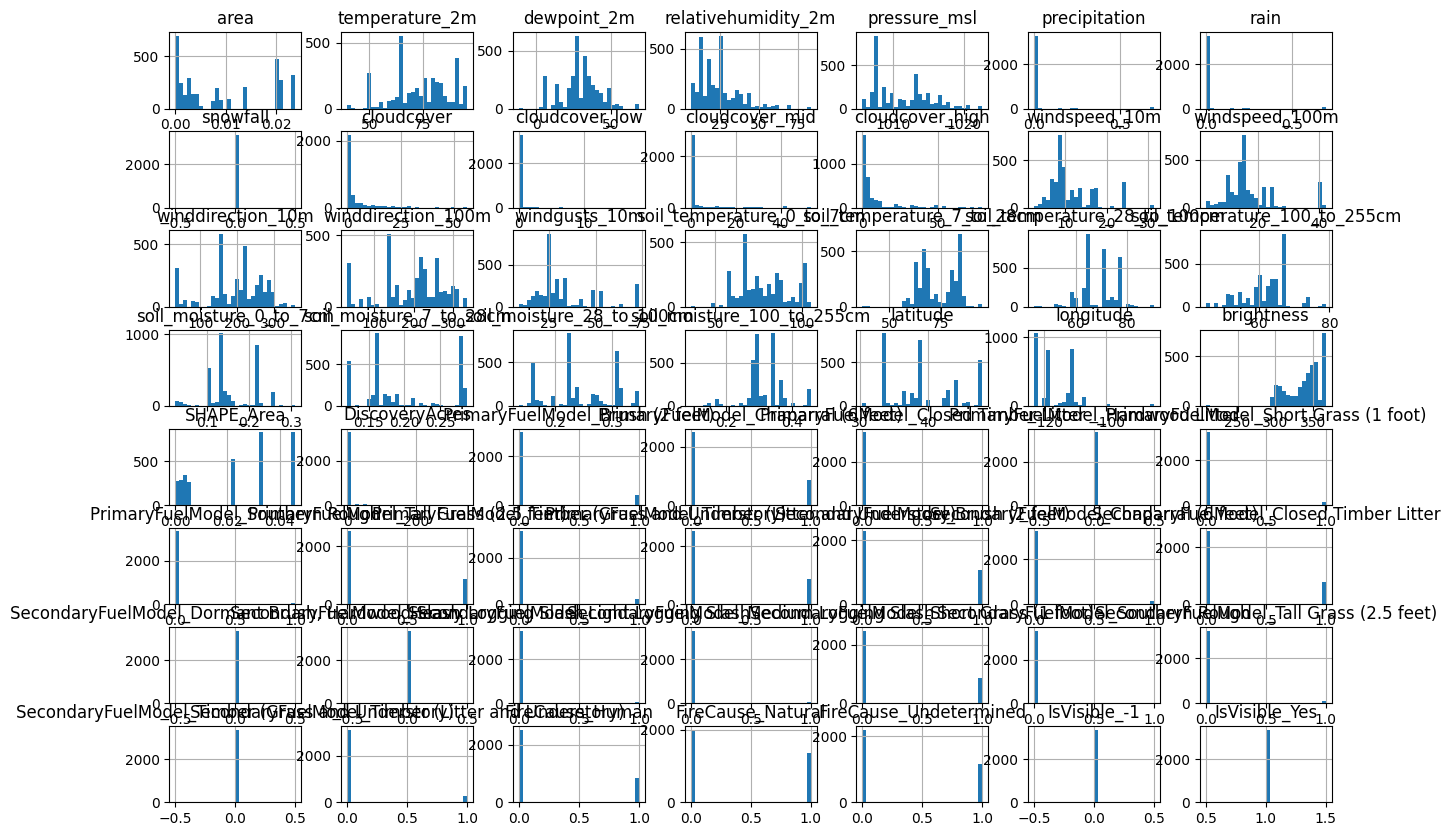

In [ ]:
X_final.hist(bins=30, figsize=(15, 10))


KeyError: ignored

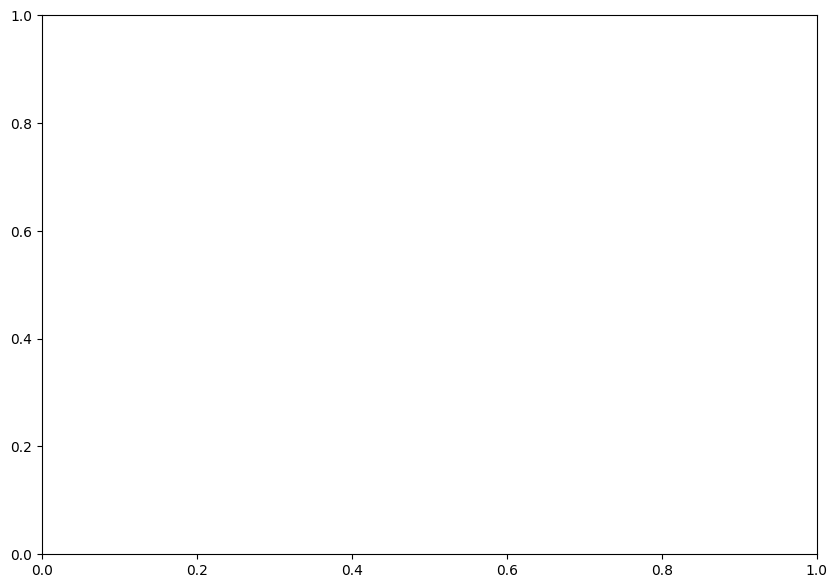

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
 
 
# Creating dataset
 
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(X_final.loc[0])
 
# Show plot
plt.show()

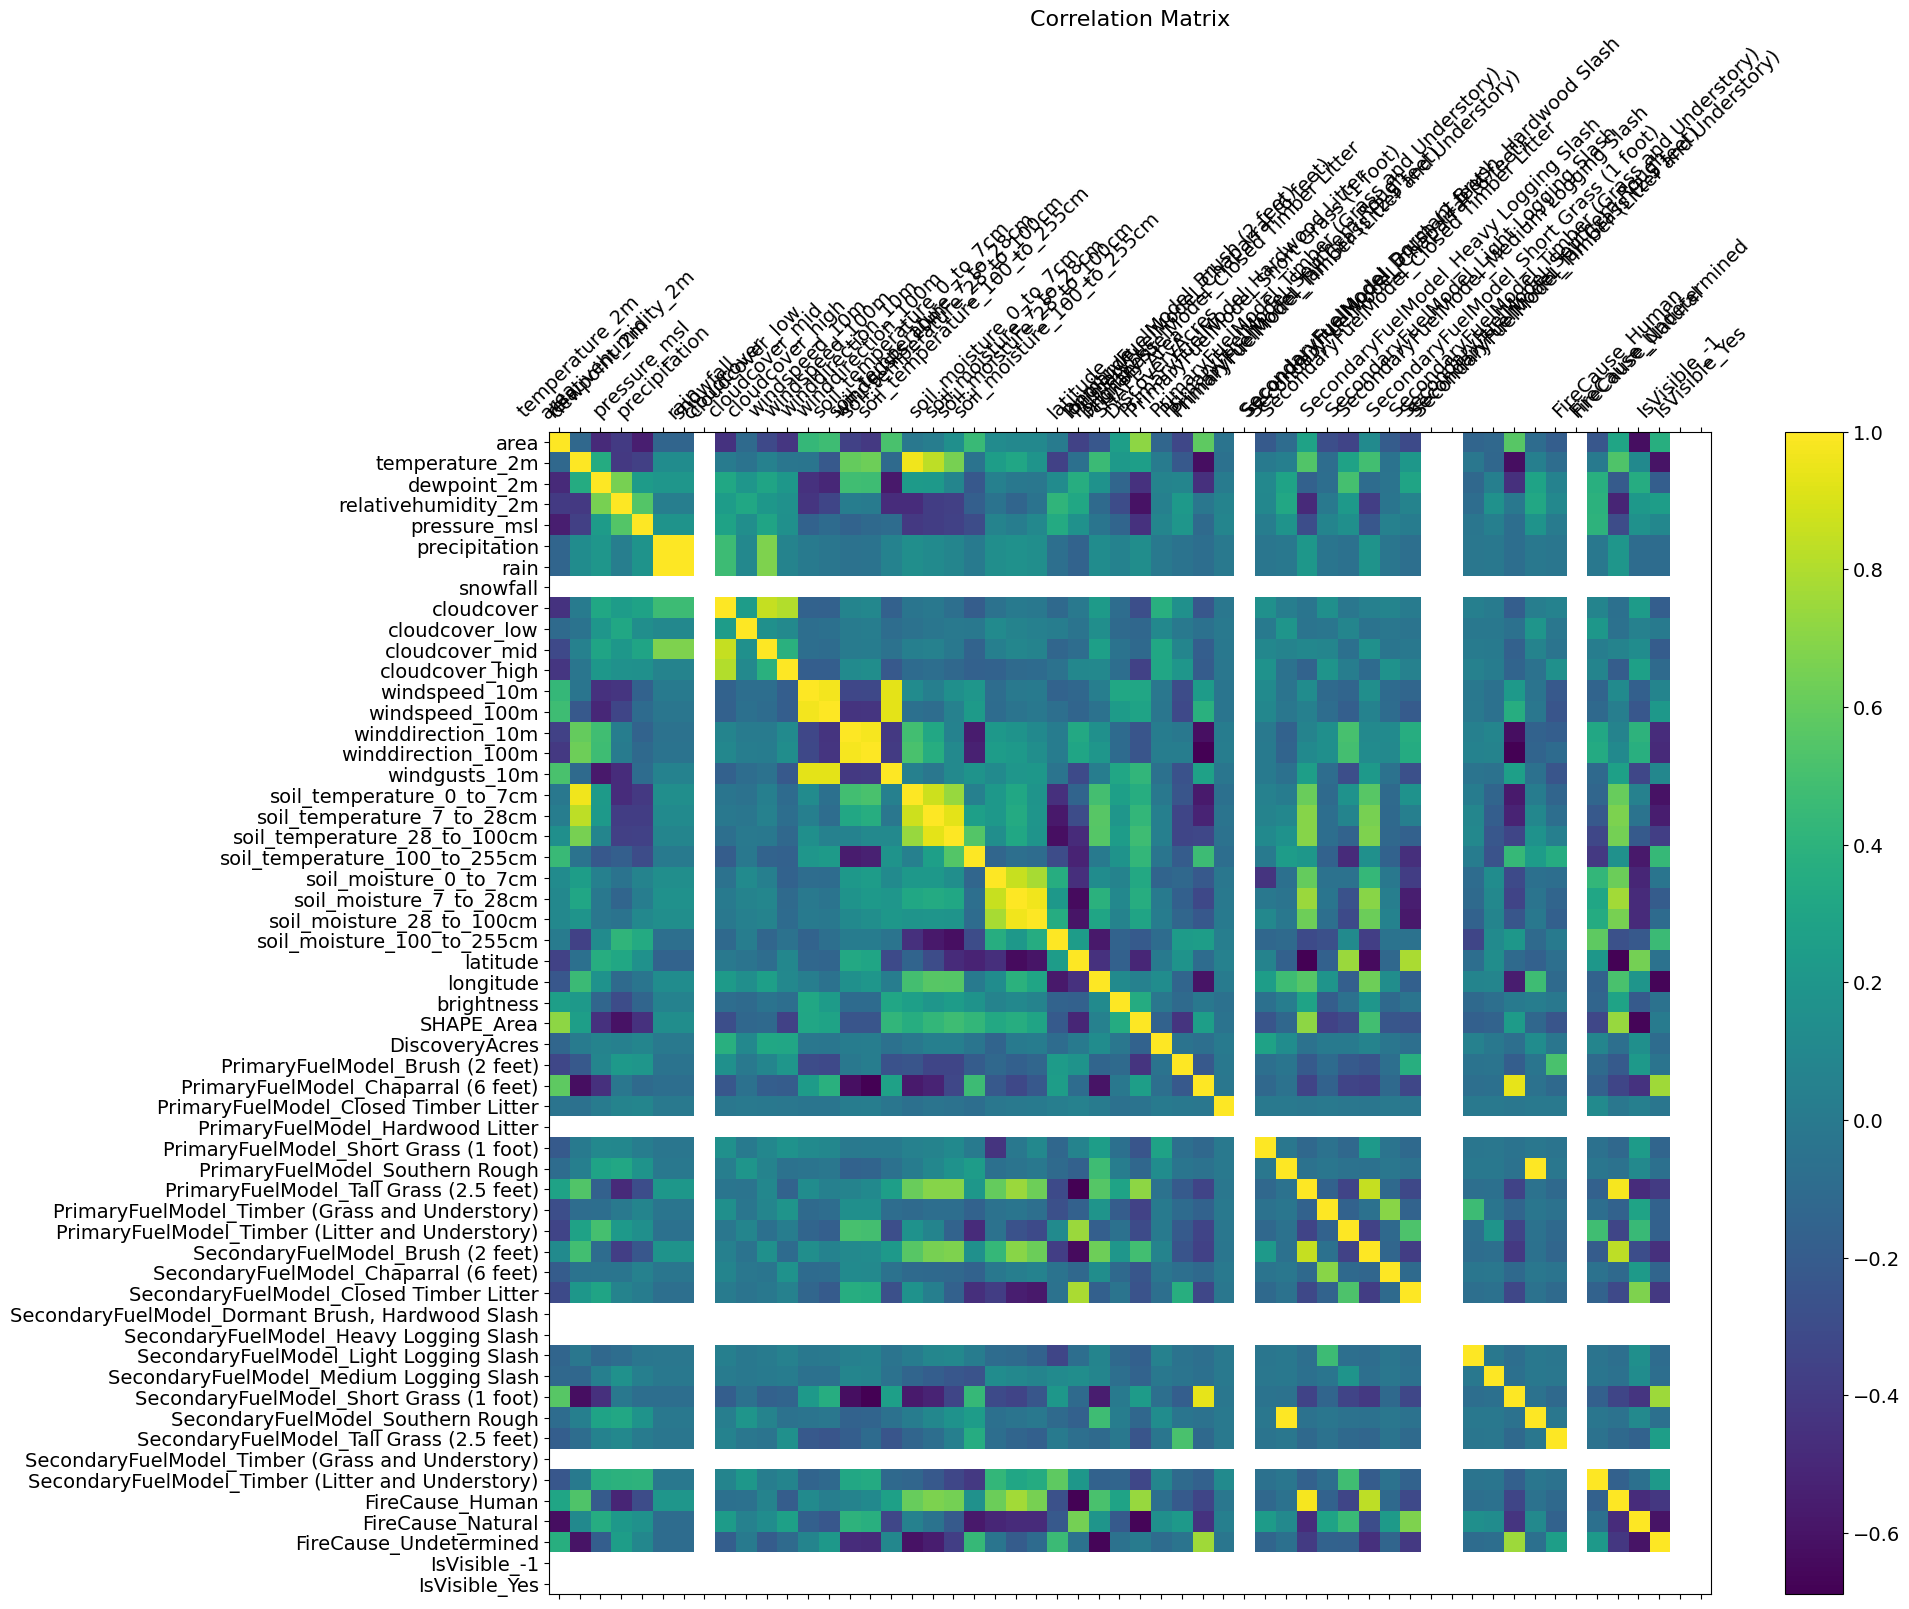

In [ ]:
import seaborn as sns
%matplotlib inline
df = X_final
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

KeyError: ignored

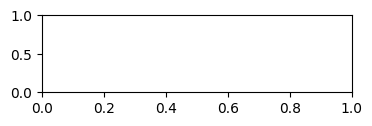

In [ ]:
X_final = data_final.iloc[:,1:57]
X_final = X_final.drop(index = inf_index)
#Y_final = data_final.iloc[:,0].drop(labels = inf_index, axis = 0)

In [ ]:
Y_final.replace([np.inf, -np.inf], np.nan, inplace=True)
Y_final.isna().sum()

292

In [ ]:
Y_final.dropna(inplace = True)
len(Y_final)

3069

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, Y_final, test_size=0.2, random_state=42)

In [ ]:
model = Lasso(alpha = 1) # uses L1 norm
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [ ]:
results = search.fit(X_train, y_train)

In [ ]:
print('MAE: %.3f' % abs(results.best_score_))
print('Config: %s' % results.best_params_)